# Creating gymnasium environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random as rd
import time

from gym import Env, spaces

In [2]:
class Coor():
    def __init__(self, coor):
        self.x = coor[0]
        self.y = coor[1]

    def get(self):
        return self.x, self.y
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __add__(self, coor2):
        return Coor((self.x + coor2.x, self.y + coor2.y))
    
    def __eq__(self, coor2):
        if coor2 == None:
            return False
        return (self.x==coor2.x) and (self.y==coor2.y)
    
    def __neg__(self):
        x,y = self.get()
        return Coor((-x,-y))
    
    def __sub__(self, coor2):
        coor = - coor2
        return self + coor
    
    def norm(self):
        x,y = self.get()
        return np.sqrt(x*x + y*y)
    
    def dist(self, coor2):
        return (self -coor2).norm()

RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GREY = [70 for _ in range(3)]
WHITE = [240 for _ in range(3)]

START_CHAR = 2
END_CHAR = 3
CAR_CHAR = 4

def color(b):
    if b == START_CHAR:
        return GREEN
    elif b == END_CHAR:
        return RED
    elif b == 1:
        return GREY
    else:
        return WHITE


class Track():
    def __init__(self, tab):
        self.height = len(tab)
        self.width = len((tab[0]))
        self.info_track = tab
        self.color_track = [[color(x) for x in y] for y in tab]

        self.end = None
        self.start = None
        for i in range(self.height):
            for j in range(self.width):
                if tab[i][j] == START_CHAR:
                    self.start = Coor((i,j))
                if tab[i][j] == END_CHAR:
                    self.end = Coor((i,j))

    def get_color(self, coor:Coor):
        """return the color of the case x,y"""
        x,y = coor.get()
        return color(self.info_track[x][y])
    
    def is_wall(self, coor:Coor):
        """Return True if case (x,y) is a wall"""
        x,y = coor.get()
        return (self.info_track[x][y] == 1)

    def get_start(self):
        """Return coordinate of start"""
        if self.start == None:
            return None
        return self.start.get()
    
    def get_end(self):
        """Return coordinate of end"""
        return self.end.get()

    def plot(self):
        """Plot the track using matplotlib"""
        plt.imshow(self.color_track)
        plt.axis("off")
        plt.show()

In [3]:
CAR_ICON = [[BLUE]]

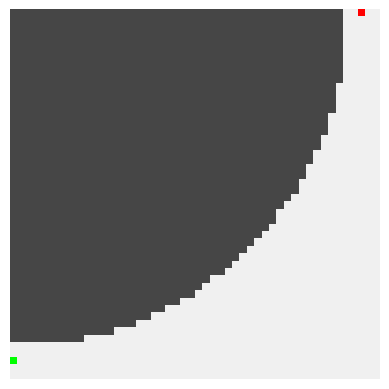

track shape: 50 50
start at coordinates: (47, 0)
end at coordinates: (0, 47)


In [4]:
track_1_info = [[1, 1, 1, 1, END_CHAR],
                [1, 1, 1, 0, 0],
                [1, 1, 0, 0, 0],
                [1, 0, 0, 0, 0],
                [START_CHAR, 0, 0, 0, 1]]

gobelin_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0],
           [START_CHAR, 1, 1, 1, 1, 1, 1, 1, END_CHAR]]


def place_circle(tab, r, pos: Coor):
    height = len(tab)
    width = len(tab[0])
    for i in range(height):
        for j in range(width):
            if pos.dist(Coor((i,j))) < r:
                tab[i][j] = 1
    return tab

N = 50
turn_1 = [[0 for _ in range(N)] for _ in range(N)]
turn_1 = place_circle(turn_1, 45, Coor((0, 0)))

turn_1[N-3][0] = START_CHAR
turn_1[0][N-3] = END_CHAR

track_1 = Track(turn_1)
track_1.plot()
print("track shape:", track_1.height, track_1.width)
print("start at coordinates:", track_1.get_start())
print("end at coordinates:", track_1.get_end())

In [5]:
class MyEnv(Env):
    def __init__(self, track: Track):
        super(MyEnv, self).__init__()

        # Define a 2-D observation space
        self.observation_shape = (track.height, track.width, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.int64)

        # Define an action space ranging from 0 to 3
        self.action_space = [i for i in range(4)]

        self.track = track
        self.car = Coor(self.track.get_start())
        # self.car_icon = cv2.imread("blue_dot.png") /255
        self.car_icon = np.array(CAR_ICON)

        self.canvas = np.array(self.track.color_track)

        self.seen = [[False for _ in range(self.track.height)] for _ in range(self.track.width)]

        self.action_meanings = {0: "Right", 1: "Left", 2: "Down", 3: "Up"}
        self.meanings_action = {"R":0, "L":1, "D":2, "U":3}
        self.moves = {0:Coor((0,1)), 1:Coor((0,-1)), 2:Coor((1,0)), 3:Coor((-1,0))}
        self.opposite_action = {0:1, 1:0, 2:3, 3:2}

    def get_opposite_action(self, action):
        return self.opposite_action[action]

    def get_state(self):
        """Return actual state of the env"""
        state = np.array(self.track.info_track)
        x,y = self.car.get()
        state[x][y] = CAR_CHAR
        return state

    def draw_car(self):
        """Add the car_icon to the canvas"""
        x,y = self.car.get()
        self.canvas[x][y] = BLUE

    def reset(self):
        """Reset the environment"""
        self.car = Coor(self.track.get_start())
        self.canvas = np.array(self.track.color_track)
        self.seen = [[False for _ in range(self.track.height)] for _ in range(self.track.width)]
        self.draw_car()
        return self.canvas

    def render(self, mode = "human", waiting_time=0.1, trajectory=[]):
        """Render the environment"""
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        self.canvas = np.array(self.track.color_track)

        traj_x = []
        traj_y = []
        for coor in trajectory:
            row,col = coor.get()
            traj_x.append(col)
            traj_y.append(row)
        plt.plot(traj_x, traj_y, "-", color="blue", markersize=2)

        self.draw_car()
        if mode == "human":
            plt.imshow(self.canvas)
            plt.axis("off")
            display.clear_output(wait=True)
            plt.show()
            time.sleep(waiting_time)
    
        elif mode == "rgb_array":
            return self.canvas
        
    def move(self, action):
        """Return the move cooresponding to action"""
        return self.moves[action]

    def is_case_ridable(self, coor: Coor):
        """Return if the car can go on the case or not"""
        x,y = coor.get()
        if not (x>=0 and x<self.track.height and y>=0 and y<self.track.width):
            return False
        return not self.track.is_wall(coor)
    
    def possible_action(self, coor=None):
        """Return a list of possible action according to the coordinates"""
        if coor==None:
            coor = self.car
        actions = []
        for i in self.moves.keys():
            if self.is_case_ridable(coor + self.moves[i]):
                actions.append(i)
        return actions
        
    def step(self, action):
        """Do a step, we suppose that the action is a possible one"""
        is_done = False
        reward = -1

        mv = self.move(action)
        next_move = self.car + mv
        reward += 2 *(next_move.dist(self.track.end) - self.car.dist(self.track.end))

        if self.seen[next_move.x][next_move.y]:
            is_done = True
            reward = -10
        self.seen[next_move.x][next_move.y] = True

        self.car = next_move

        if self.car == self.track.end:
            reward = 1000
            is_done = True

        

        return self.canvas, reward, is_done, [self.car, self.track.end]
    
    def random_action(self):
        """Return random possible action"""
        return rd.choice(self.possible_action())
        
        

env = MyEnv(track_1)

# Genetic algo

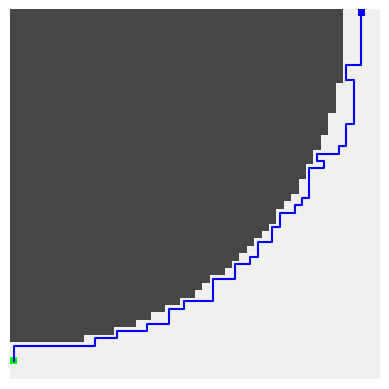

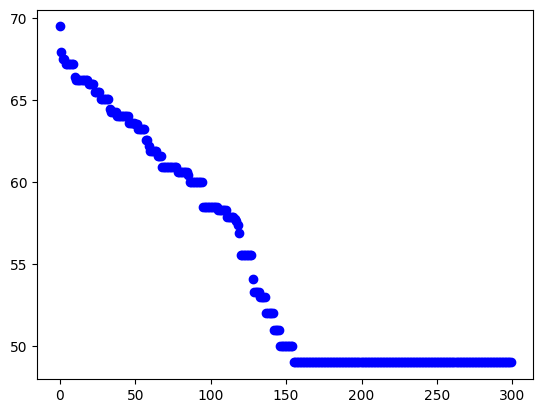

In [8]:
LEN_POP = 500

class Indiv():
    def __init__(self, actions=[], sc=None):
        self.actions = actions
        self.score = sc

def continue_indiv(indiv, show=False, wt=0.01):
    score = 0
    env.reset()
    trajectory = [env.car]

    running = True
    step = 0
    while running:
        # Choice of next action
        if step < len(indiv.actions):
            action = indiv.actions[step]
        else:
            possible_choices = env.possible_action(env.car)
            
            if step > 0:
                possible_choices.remove(env.get_opposite_action(indiv.actions[-1]))
                if possible_choices != []:
                    action = rd.choice(possible_choices)
                else:
                    action = env.get_opposite_action(indiv.actions[-1])
            else:
                action = rd.choices(possible_choices)[0]
            indiv.actions.append(action)

        # Simulation
        obs, reward, done, infos = env.step(action)
        score += reward
        trajectory.append(env.car)

        # Render the game
        if show:
            env.render(waiting_time=wt, trajectory=trajectory)
        if done == True:
            running = False

        step += 1

    indiv.score =  env.car.dist(env.track.end) + step/2
    return indiv


def gen_indiv():
    return continue_indiv(Indiv())

def gen_pop():
    return [gen_indiv() for i in range(LEN_POP)]

def mutate_indiv(indiv: Indiv):
    if rd.random() < 0.3:
        del indiv.actions[-1]
    else:
        x = rd.randint(0, len(indiv.actions)-2)
        indiv.actions = indiv.actions[:x]
    return continue_indiv(indiv)

def cross_over(indiv1, indiv2):
    #TODO
    return copy_indiv(indiv1)

def sort_pop(pop):
    pop.sort( key = lambda x: x.score)

def copy_indiv(indiv: Indiv):
    return Indiv([x for x in indiv.actions], indiv.score)

def select_pop(pop):
    new_pop = []
    pourcentage = 0
    k = int( (1 + np.sqrt(1 + 8*pourcentage*LEN_POP)) / 2 ) 

    for i in range( int(0.2*LEN_POP) ):
        new_pop.append(pop[i])
        
    for i in range(k):
        for j in range(i+1, k):
            new_pop.append(cross_over(pop[i], pop[j]))
    
    for i in range(int(LEN_POP*0.4)):
        new_indiv = copy_indiv(pop[i])
        new_indiv = mutate_indiv(new_indiv)
        new_pop.append(new_indiv)

    while (len(new_pop) != LEN_POP):
        new_pop.append(gen_indiv())

    return new_pop


def algo_gen():
    NB_GEN = 300
    pop = gen_pop()
    score_liste = []
    for gen in range(NB_GEN):
        sort_pop(pop)
        pop = select_pop(pop)

        if gen % 10 == 0:
            print(gen, end=" ")
        if (gen+1) % 50 == 0:
            print(pop[0].actions)
            continue_indiv(pop[0], show=True, wt=0.01)
        score_liste.append(pop[0].score)
    
    for gen,sc in enumerate(score_liste):
        plt.plot(gen, sc, 'o', color='blue')
    plt.show()
    return pop[0]
        
best = algo_gen()


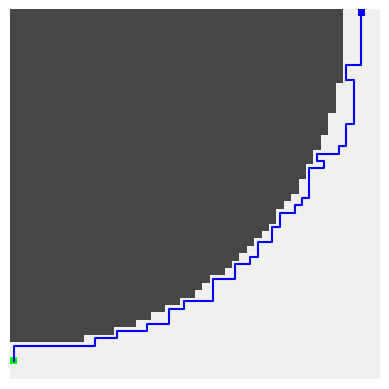

In [9]:
#best = Indiv([0,0,0,0,0,0,0,0,0])
continue_indiv(best, show=True, wt=0.001)
env.close()